In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

## Create our custom datset object

In [2]:
class MassachusettsRoadsDataset(Dataset):
    """
    Massachusetts Roads Dataset
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(((".tiff")))]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx: int):
        #Load image and mask
        img_path = os.path.join(self.image_dir, self.images[idx])
        #Labels in the Massachusets
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".tiff", ".tif"))
        image = Image.open(img_path).convert("RGB")
        #Get the label in grayscale
        mask = Image.open(mask_path).convert("L")
        #Convert image and mask to array in case augmentation using albumentations
        image = np.array(image)
        mask = np.array(mask)
        #Apply transform with Albumentation (remember Albumentations needs np.arrays!)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = torch.tensor(augmented['mask'], dtype=torch.long)
        else:
            #Conver to tensor
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)/255
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask, self.images[idx]
 


## Create dataloaders

In [3]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

bs = 16 #batch size

tr_img_dir = "dataset/tiff/train"
tr_mask_dir = "dataset/tiff/train_labels"
val_img_dir = "dataset/tiff/val"
val_mask_dir = "dataset/tiff/val_labels"
test_img_dir = "dataset/tiff/test"
test_mask_dir = "dataset/tiff/test_labels"

# Definir transformaciones
transform = A.Compose([
    A.Resize(512, 512),  # Resize
    A.HorizontalFlip(p=0.5),  # Horizontal Flip
    A.RandomBrightnessContrast(p=0.2),  # Adjust brightness/contrast
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.4), #Shift, scale and rotate an image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImgNet normalization values
    ToTensorV2()  # Convertir a tensores
])

#Create datasets
tr_ds = MassachusettsRoadsDataset(tr_img_dir, tr_mask_dir, transform)
val_ds = MassachusettsRoadsDataset(val_img_dir, val_mask_dir, transform)
test_ds = MassachusettsRoadsDataset(test_img_dir, test_mask_dir)
#Create dataloaders (random split)
tr_dl = DataLoader(tr_ds, bs, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, bs, shuffle=True, num_workers=4)
test_dl = DataLoader(val_ds, 1, shuffle=False, num_workers=4)

/home/edu_pc/miniforge3/envs/env_general/lib/python3.11/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Data visualization

In [4]:
def denormalize_image(tensor):
    # Tensor images in PyTorch are [C x H x W]
    # Imagenet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalization: multiply by std and sum mean
    image_np = tensor.cpu().detach().squeeze().permute(1, 2, 0).numpy()  #Convert tu numpy HWC
    image_np = image_np * std + mean  
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)  # Scale to rage 0-255 and convert to uint8
    
    return image_np


In [6]:
from matplotlib import pyplot as plt
import random

def visualize_data(data, n_imgs, rows, is_batch=False):
    """
    Visualize images and masks from a dataset or DataLoader batch.
    
    Parameters:
    - data: Dataset object or DataLoader batch (tuple of images, masks, names).
    - n_imgs: Number of images and masks to visualize.
    - rows: Number of rows in the visualization grid.
    - is_batch: Boolean flag indicating if data comes from a batch (default: False).
    """
    # Handle batch or dataset input
    if is_batch:
        batch_images, batch_masks, batch_names = next(iter(data))
        images = batch_images[:n_imgs]
        masks = batch_masks[:n_imgs]
        names = batch_names[:n_imgs]
    else:
        # Random indices for plotting
        indices = [random.randint(0, len(data) - 1) for _ in range(n_imgs)]
        images, masks, names = zip(*[data[idx] for idx in indices])
    
    # Create two figures for images and masks
    fig_images = plt.figure(figsize=(20, 10))
    fig_masks = plt.figure(figsize=(20, 10))
    
    for i in range(n_imgs):
        # Retrieve image and mask
        img_tensor = images[i]
        mask_tensor = masks[i]
        img_name = names[i]
        
        # Convert image and mask to numpy arrays for visualization
        img = denormalize_image(img_tensor) if is_batch else img_tensor.permute(1, 2, 0).numpy()  # CHW to HWC
        mask = mask_tensor.numpy()  # Masks are grayscale
        
        # Add image to the first figure
        plt.figure(fig_images.number)
        plt.subplot(rows, n_imgs // rows, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {img_name}")
        
        # Add mask to the second figure
        plt.figure(fig_masks.number)
        plt.subplot(rows, n_imgs // rows, i + 1)
        plt.imshow(mask, cmap="gray")
        plt.axis("off")
        plt.title(f"Mask {img_name}")
    
    # Show both figures
    fig_images.suptitle("Images", fontsize=16)
    fig_masks.suptitle("Masks", fontsize=16)
    fig_images.tight_layout()
    fig_masks.tight_layout()
    plt.show()

### Visualize images from the dataset (not augmented)

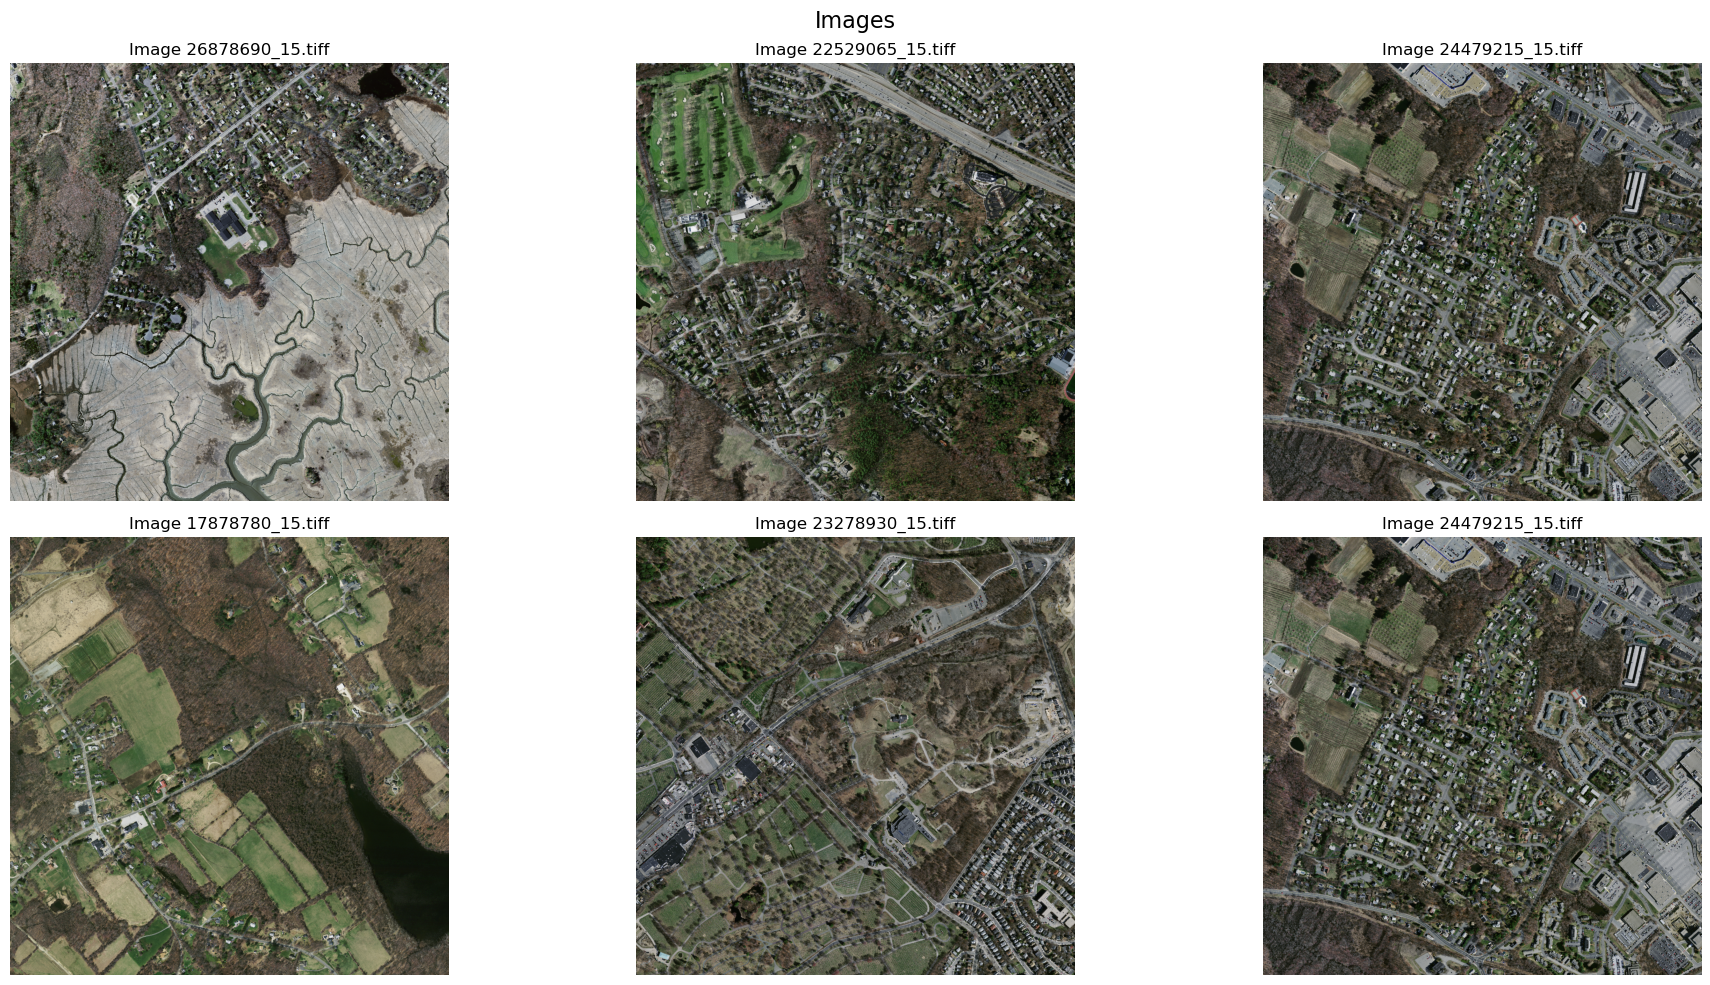

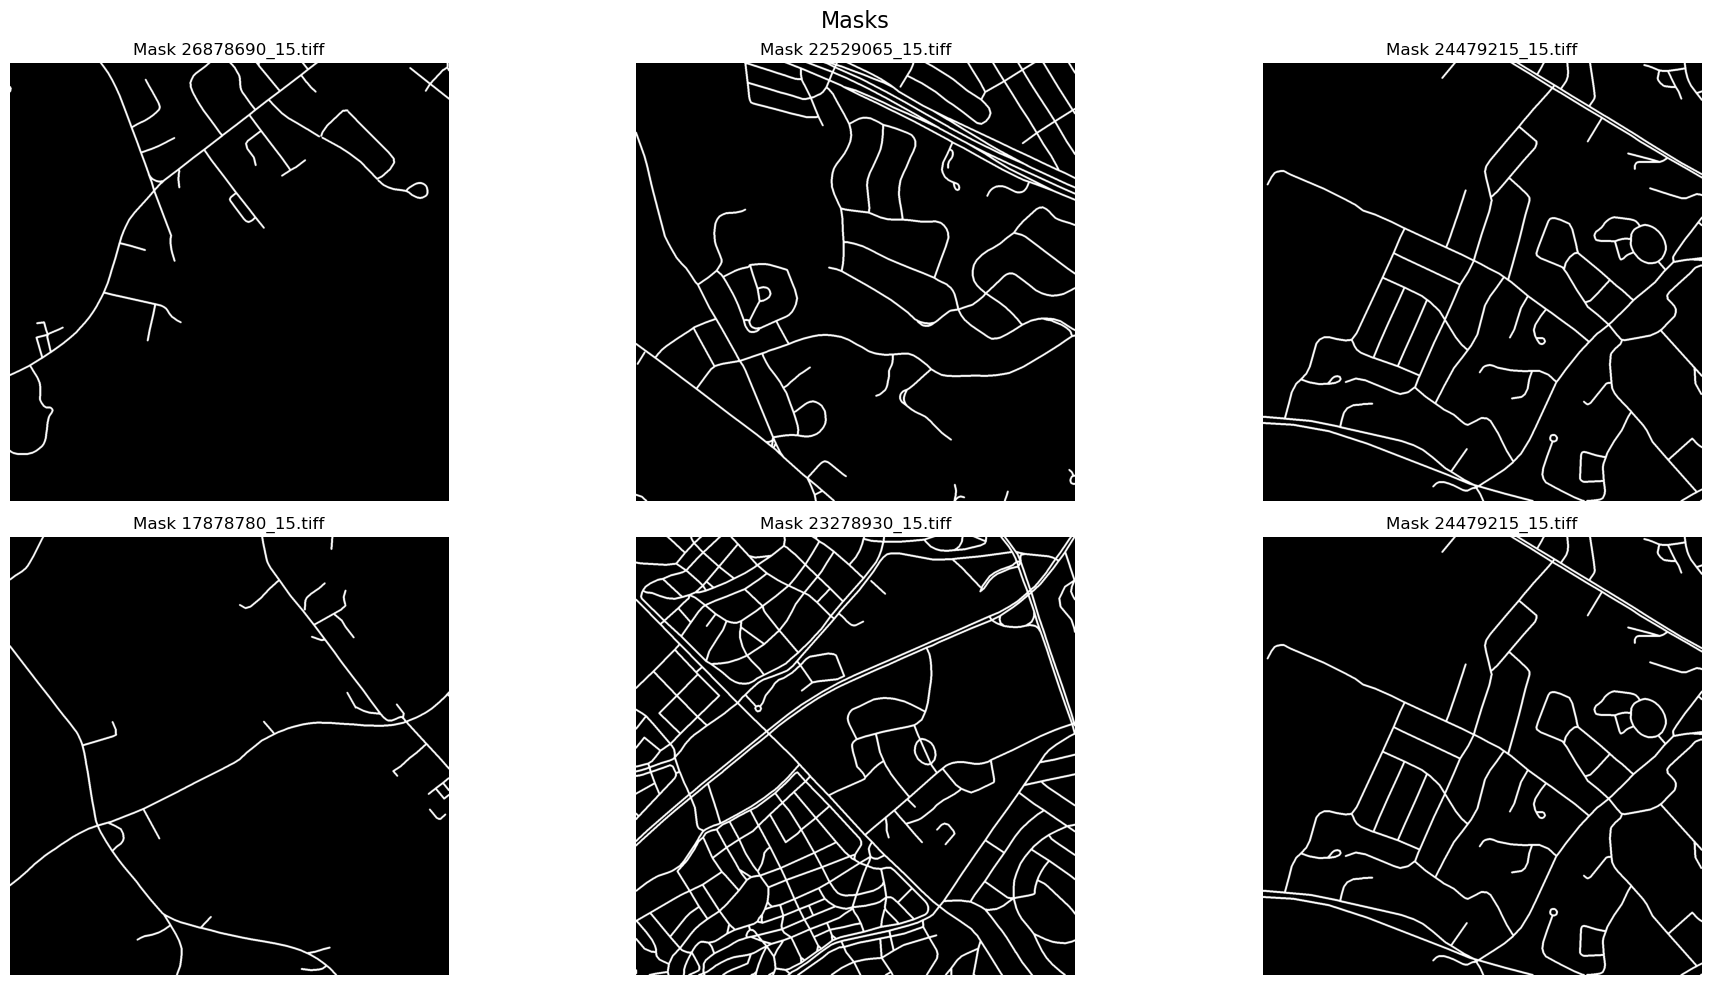

In [7]:
visualize_data(data=test_ds, n_imgs=6, rows=2) #Test not transformed, that's why we viz that


### Visualize images from the dataloaders (with augmentations)

/tmp/ipykernel_87993/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_87993/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_87993/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_87993/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

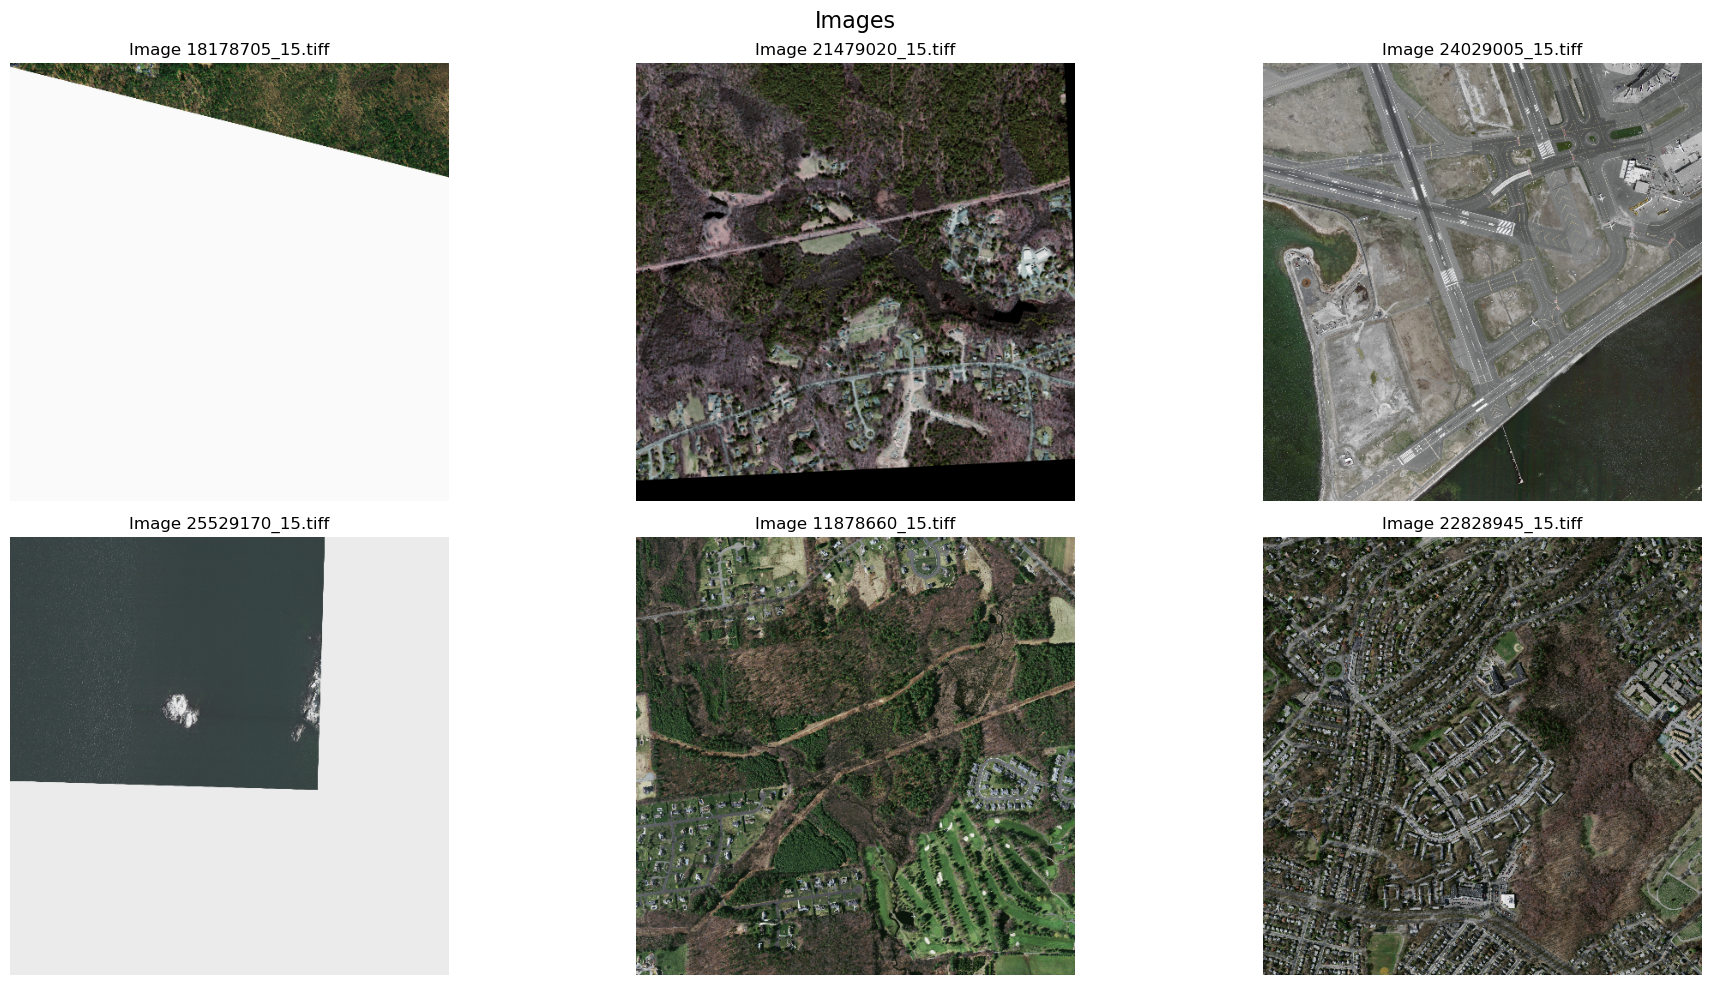

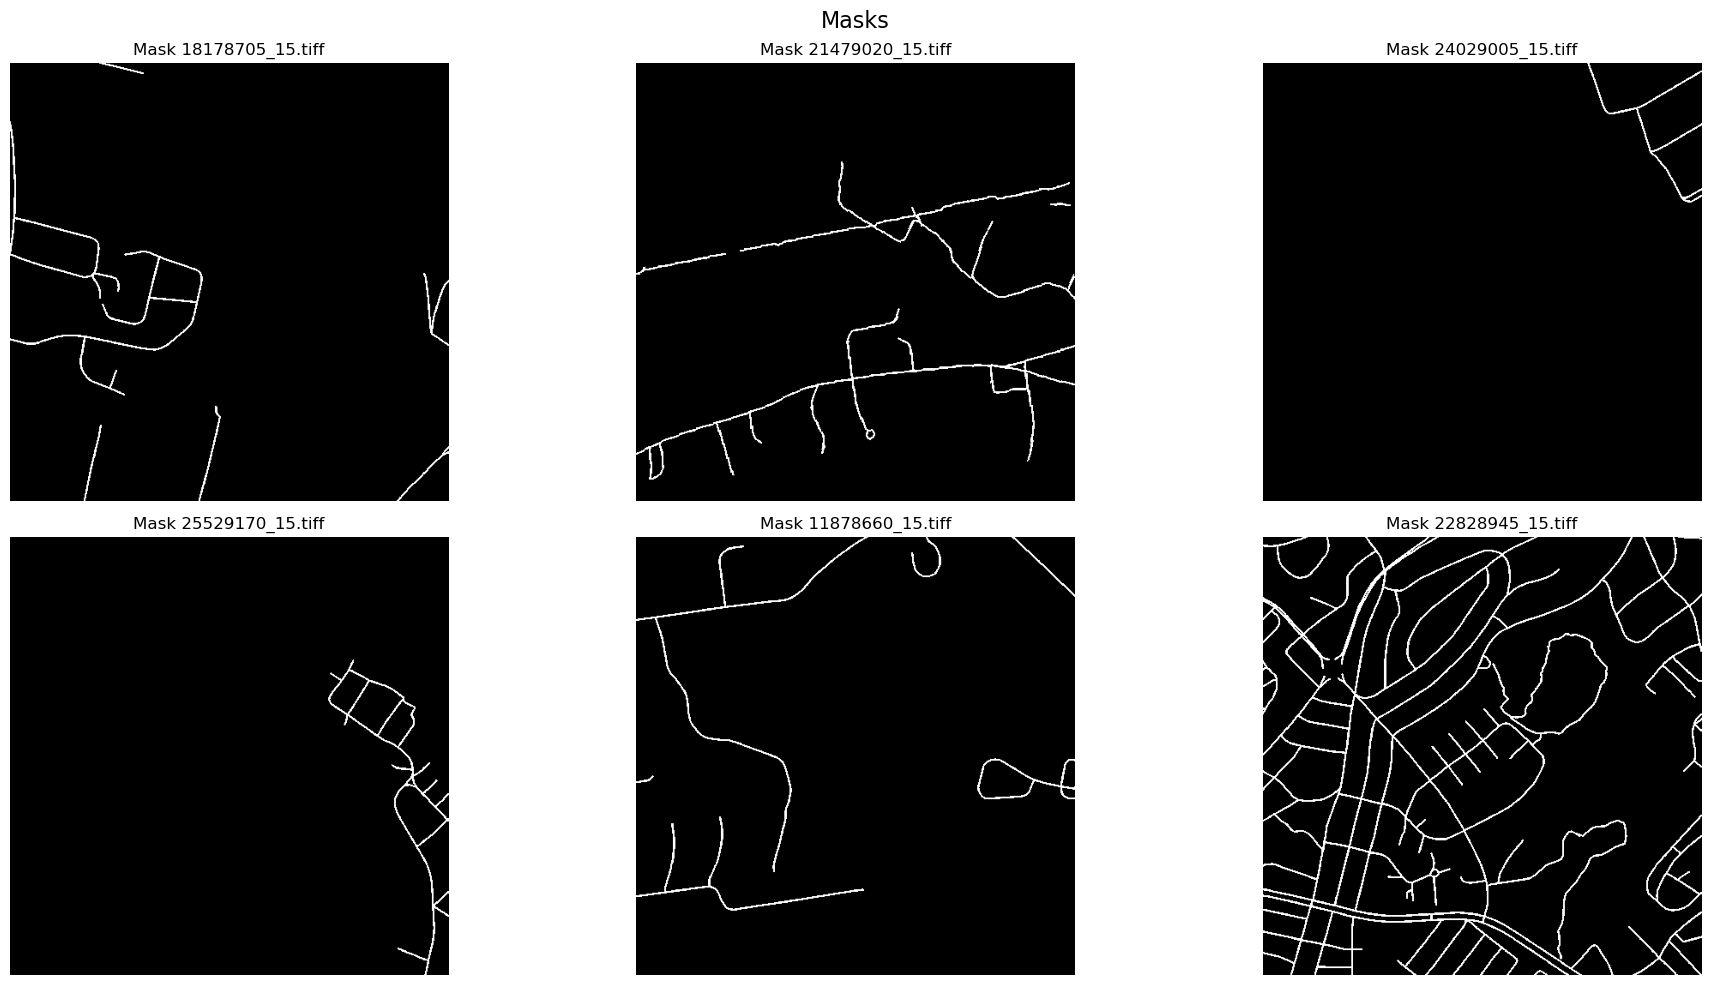

In [17]:
visualize_data(tr_dl, 6, 2,is_batch=True) #is_batch=True is for dataloaders with aug

In [18]:
import importlib
import src.metrics, src.training_seg  # Suponiendo que este es tu módulo
importlib.reload(src.metrics)  # Recarga el módulo para reflejar cambios
importlib.reload(src.training_seg)

<module 'src.training_seg' from '/home/edu_pc/Projects/Road_Segmentation/src/training_seg.py'>

In [19]:
torch.cuda.empty_cache()

### Model definition and training

In [8]:
import segmentation_models_pytorch as smp
from src.training_seg import *
from torch.amp import GradScaler

#Definition of all the hyperparameters and other info to track
hyperparams = {
    "experiment_name": "Road Segmentation - Massachusets",
    "lr": 1e-4,
    "bs": bs,  # Defined when creating the dataloaders
    "epochs": 15,
    "optimizer": "Adam",
    "scheduler": "StepLR",
    "precision FP16": True,
    "model_type": "DeepLabV3+",
    "encoder_name": "efficientnet-b4",
    "num_classes": 2
}
#Initialize a variable to track validation loss (used for saving best model)
best_val_loss = float("inf")
#Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
#Define the model
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2
)
#Initialize MLflow
mlflow.set_experiment(hyperparams["experiment_name"])
with mlflow.start_run() as run:
    #Log hyperparams
    mlflow_log_hyp(hyperparams)
    #Get therun ID
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")


#Initialize setup for our transfer learning
model, epochs, device,  loss_fn, optimizer, scheduler = setup_train(model, device, hyperparams)
#Create GradScaler for FP16 mixup calcs
scaler = GradScaler()

for epoch in range(epochs):
    #Train Step
    train_metrics = train_one_epoch(model, tr_dl, device, loss_fn, optimizer, scaler, epoch)
    #Val step
    val_metrics = valite_one_epoch(model, val_dl, device, loss_fn, epoch)
    #Print metrics
    print(f"Epoch {epoch + 1}: {train_metrics} | {val_metrics}")
    #Save model if val_loss is better tha previous epoch
    save_best_model(model, val_metrics, best_val_loss, hyperparams["experiment_name"], run_id, epoch)

#During our training, we are creating a summarywriter object for tensorboad. Once train is finished, close it.    
#Good practice is to clear memory
del optimizer
del loss_fn
del scaler
torch.cuda.empty_cache()


Run ID: 8ed86029f4f24932906bc49aeeab5e96


  0%|          | 0/70 [00:00<?, ?it/s]/tmp/ipykernel_94152/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_94152/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_94152/1314616382.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_94152/1314616382.py:29: UserWarning: To copy construct from a ten

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
# Cargar una máscara y verificar su tipo y valores únicos
from torchvision.transforms import ToTensor
import torch

# Instanciar tu dataset
mask_dir = "dataset/tiff/train_labels"  # Cambia al directorio de las máscaras
img_dir = "dataset/tiff/train"          # Cambia al directorio de las imágenes
dataset = MassachusettsRoadsDataset(img_dir, mask_dir)

# Seleccionar una muestra (idx=0 como ejemplo)
image, mask, filename = dataset[3]  # Cambia el índice según lo necesites

# Mostrar el nombre de la máscara
print(f"Mask filename: {filename}")

# Verificar tipo de la máscara
print(f"Mask dtype: {mask.dtype}")  # Debe ser torch.int64

# Verificar valores únicos
print(f"Unique values in mask: {torch.unique(mask)}")  # Esto muestra los valores presentes (por ejemplo, 0, 1 para binario)

Mask filename: 20878915_15.tiff
Mask dtype: torch.int64
Unique values in mask: tensor([  0, 255])
